In [1]:
from fast_rl.agents.dqn import create_dqn_model, dqn_learner
from fast_rl.agents.dqn_models import *
from fast_rl.agents.dqn import *
from fast_rl.core.agent_core import ExperienceReplay, PriorityExperienceReplay,  GreedyEpsilon
from fast_rl.core.data_block import MDPDataBunch
from fast_rl.core.metrics import RewardMetric, EpsilonMetric
from fastai.gen_doc.nbdoc import show_doc
from fast_rl.core.train import GroupAgentInterpretation, AgentInterpretation
from fastai.basic_data import DatasetType

Can't import one of these: No module named 'pybullet'
Can't import one of these: No module named 'gym_maze'
Can't import one of these: No module named 'gym_minigrid'


## Databunch for Training / Validation
For reinforcement learning, training might take a long time.

Note that if you want to avoid validation running, just turn it off and reflect the change in 
the interpretation objects. The agent will train much faster, and then you could validate later.
```python
data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', add_valid=False, bs=128)
AgentInterpretation(learn=learn, ds_type=DatasetType.Train)
```

In [11]:
data = MDPDataBunch.from_env('CartPole-v1', render='human', bs=64, add_valid=False)

In [12]:
show_doc(DQNModule.__init__)

<h4 id="DQNModule.__init__" class="doc_header"><code>__init__</code><a class="source_link" data-toggle="collapse" data-target="#DQNModule-__init__-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>__init__</code>(**`ni`**:`int`, **`ao`**:`int`, **`layers`**:`Collection`\[`int`\], **`discount`**:`float`=***`0.99`***, **`lr`**=***`0.001`***, **`n_conv_blocks`**:`Collection`\[`int`\]=***`0`***, **`nc`**=***`3`***, **`opt`**=***`None`***, **`emb_szs`**:`ListSizes`=***`None`***, **`loss_func`**=***`None`***, **`w`**=***`-1`***, **`h`**=***`-1`***, **`ks`**:`Union`\[`NoneType`, `list`\]=***`None`***, **`stride`**:`Union`\[`NoneType`, `list`\]=***`None`***, **`grad_clip`**=***`5`***, **`conv_kern_proportion`**=***`0.1`***, **`stride_proportion`**=***`0.1`***, **`pad`**=***`False`***, **`batch_norm`**=***`False`***)

<div class="collapse" id="DQNModule-__init__-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#DQNModule-__init__-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>__init__</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Basic DQN Module. Args:
        ni: Number of inputs. Expecting a flat state `[1 x ni]`
        ao: Number of actions to output.
        layers: Number of layers where is determined per element.
        n_conv_blocks: If `n_conv_blocks` is not 0, then convolutional blocks will be added
                                   to the head on top of existing linear layers.
        nc: Number of channels that will be expected by the convolutional blocks. 

In [13]:
show_doc(BaseDQNTrainer.__init__)
show_doc(BaseDQNTrainer.on_loss_begin)

<h4 id="BaseDQNTrainer.__init__" class="doc_header"><code>__init__</code><a class="source_link" data-toggle="collapse" data-target="#BaseDQNTrainer-__init__-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>__init__</code>(**`learn`**:`DQNLearner`, **`max_episodes`**=***`None`***)

<div class="collapse" id="BaseDQNTrainer-__init__-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#BaseDQNTrainer-__init__-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>__init__</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handles basic DQN end of step model optimization.  

<h4 id="BaseDQNTrainer.on_loss_begin" class="doc_header"><code>on_loss_begin</code><a class="source_link" data-toggle="collapse" data-target="#BaseDQNTrainer-on_loss_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_loss_begin</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="BaseDQNTrainer-on_loss_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#BaseDQNTrainer-on_loss_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_loss_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Performs tree updates, exploration updates, and model optimization.  

The batch size will be defined in the data class because `DataBunches` already require a 
batch size input. This batch size will be used by the model during optimization.

## Experience Replay

In [ ]:
memory = ExperienceReplay(memory_size=1000000, reduce_ram=True)
explore = GreedyEpsilon(epsilon_start=1, epsilon_end=0.1, decay=0.001)
model = create_dqn_model(data=data, base_arch=DQNModule, lr=0.001, layers=[32,32], opt=optim.RMSprop)
learn = dqn_learner(data, model, memory=memory, exploration_method=explore, 
                    callback_fns=[RewardMetric, EpsilonMetric])
learn.fit(3)

In [ ]:
interp = AgentInterpretation(learn, ds_type=DatasetType.Train)

In [ ]:
interp.plot_rewards(cumulative=True, per_episode=True, group_name='er_rms')

We can also pipe-line this to truly see how our model actually performs.

In [ ]:
group_interp = GroupAgentInterpretation()
group_interp.add_interpretation(interp)
for i in range(5):
    data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32, add_valid=False)
    model = create_dqn_model(data=data, base_arch=DQNModule, lr=0.001, layers=[32,32], opt=optim.RMSprop)
    memory = ExperienceReplay(memory_size=1000000, reduce_ram=True)
    explore = GreedyEpsilon(epsilon_start=1, epsilon_end=0.1, decay=0.001)
    learn = dqn_learner(data, model, memory=memory, exploration_method=explore, 
                        callback_fns=[RewardMetric, EpsilonMetric])
    learn.fit(3)
    interp = AgentInterpretation(learn, ds_type=DatasetType.Train)
    interp.plot_rewards(cumulative=True, per_episode=True, group_name='er_rms', no_show=True)
    group_interp.add_interpretation(interp)
    group_interp.to_pickle('data/dqn', 'dqn_er_rms')
    data.close()

Below are runs produced by `test_dqn.py`

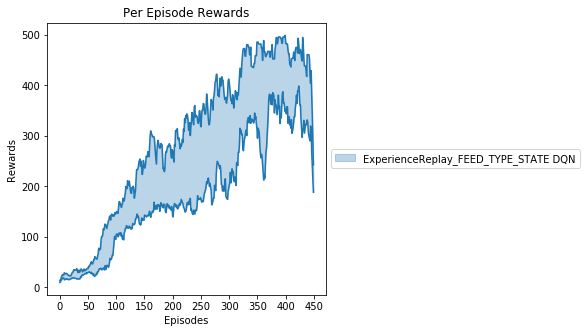

In [14]:
group_interp = GroupAgentInterpretation.from_pickle('data/cartpole_dqn', 'dqn_ExperienceReplay_FEED_TYPE_STATE')
group_interp.plot_reward_bounds(per_episode=True, smooth_groups=10)

In [15]:
[g.analysis for g in group_interp.groups]

[{'average': 235.88644444444444, 'max': 499.0, 'min': 10.8, 'type': 'reward'},
 {'average': 209.4431111111111, 'max': 446.1, 'min': 10.0, 'type': 'reward'},
 {'average': 272.5126666666667, 'max': 495.9, 'min': 11.5, 'type': 'reward'},
 {'average': 246.3011111111111, 'max': 431.1, 'min': 10.1, 'type': 'reward'},
 {'average': 200.82066666666665, 'max': 493.3, 'min': 14.0, 'type': 'reward'}]

## Priority Experience Replay

Another form of experience is Priority Experience Replay (PER). You will notice it does not perform as well. This is because PER usually does better after around a sample size of 1,000,000. 

In [ ]:
per_group_interp = GroupAgentInterpretation()
per_group_interp.add_interpretation(interp)
for i in range(4):
    data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32)
    model = create_dqn_model(data=data, base_arch=DQNModule, lr=0.001, layers=[32,32], opt=optim.RMSprop)
    memory = PriorityExperienceReplay(memory_size=1000000, reduce_ram=True)
    explore = GreedyEpsilon(epsilon_start=1, epsilon_end=0.1, decay=0.001)
    learn = dqn_learner(data, model, memory=memory, exploration_method=explore, 
                        callback_fns=[RewardMetric, EpsilonMetric])
    learn.fit(3)
    interp = AgentInterpretation(learn, ds_type=DatasetType.Train)
    interp.plot_rewards(cumulative=True, per_episode=True, group_name='per_rms', no_show=True)
    per_group_interp.add_interpretation(interp)
    group_interp.to_pickle('data/dqn', 'dqn_per')
    data.close()

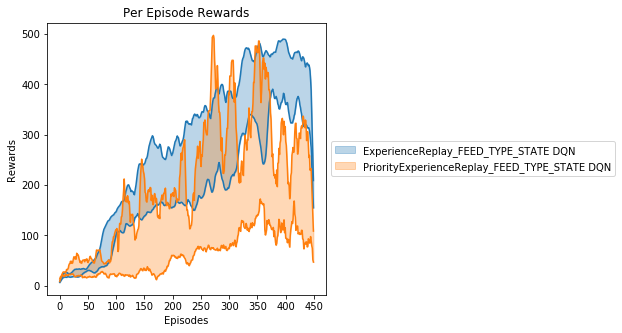

In [16]:
per_group_interp = GroupAgentInterpretation.from_pickle('data/cartpole_dqn', 'dqn_PriorityExperienceReplay_FEED_TYPE_STATE')
per_group_interp.add_interpretation(group_interp)
per_group_interp.plot_reward_bounds(per_episode=True, smooth_groups=10)

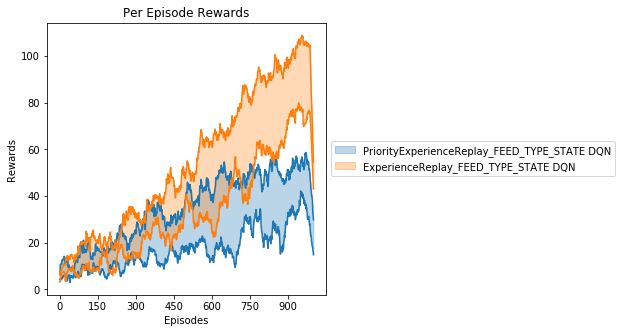

In [5]:
per_group_interp = GroupAgentInterpretation.from_pickle('data/lunarlander_dqn', 'dqn_ExperienceReplay_FEED_TYPE_STATE')
per_group_interp.add_interpretation(
    GroupAgentInterpretation.from_pickle('data/lunarlander_dqn', 'dqn_PriorityExperienceReplay_FEED_TYPE_STATE')
)
per_group_interp.plot_reward_bounds(per_episode=True, smooth_groups=30)

In [ ]:
per_group_interp.analysis